In [1]:
#Hammer Price를 정렬한 후 상위 50% = 1, 하위 50% = 2 변환 후 분류
#모델 : 로지스틱 회귀, 나이브 베이즈, SVM, knn
#전처리와 파생변수 제작, 변수선택의 근거
#예측 후 모델간 비교
#grid serch(svm, knn)
#5-fold로 정확도 검증

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tnrange,tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate as CV



## 1. EDA & 전처리

In [5]:
#파일 불러오기
import os
import pandas as pd
os.chdir("C:/Users/dmstj/tb_py/2주차")
data = pd.read_csv("./svm/Auction_master_train.csv")
data.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,...,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,...,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,...,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,...,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,...,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


In [6]:
#1933개의 데이터와 41개의 피쳐로 이루어짐
print(data.shape)

(1933, 41)


In [7]:
#오늘로부터 이 날짜가 얼마나 지났느냐를 보려고 만든 함수
def change_datetime(x):
    today = datetime.date.today()
    #년, 월 , 일 int(숫자형식)으로 바꿔서 datetime형식으로 넣음
    someday = datetime.date(int(x[:4]), int(x[5:7]), int(x[8:10]))
    #오늘 뺴기 헤당 날짜
    diff = today - someday
    return diff.days

In [8]:
#날짜까지만 뽑게 apply시켜준다
data["Appraisal_date"] = data["Appraisal_date"].apply(lambda x : x[:10])
data["First_auction_date"] = data["First_auction_date"].apply(lambda x : x[:10])
data["Final_auction_date"] = data["Final_auction_date"].apply(lambda x : x[:10])
data["Preserve_regist_date"] = data["Preserve_regist_date"].apply(lambda x : x[:10])
data["Close_date"] = data["Close_date"].apply(lambda x : x[:10])

In [9]:
#오늘로부터 얼마나 지났는지 모두 바꾸는 apply
data["Appraisal_date"] = data["Appraisal_date"].apply(change_datetime)
data["First_auction_date"] = data["First_auction_date"].apply(change_datetime)
data["Final_auction_date"] = data["Final_auction_date"].apply(change_datetime)
data["Preserve_regist_date"] = data["Preserve_regist_date"].apply(change_datetime)
data["Close_date"] = data["Close_date"].apply(change_datetime)

In [10]:
#결측값 확인 
#addr_li, addr_bunji2, Specific, road_bunji2 : 1000개 이상 결측값
#road_bunji1 : 24개의 결측값
data.isnull().sum()

Auction_key                       0
Auction_class                     0
Bid_class                         0
Claim_price                       0
Appraisal_company                 0
Appraisal_date                    0
Auction_count                     0
Auction_miscarriage_count         0
Total_land_gross_area             0
Total_land_real_area              0
Total_land_auction_area           0
Total_building_area               0
Total_building_auction_area       0
Total_appraisal_price             0
Minimum_sales_price               0
First_auction_date                0
Final_auction_date                0
Final_result                      0
Creditor                          0
addr_do                           0
addr_si                           0
addr_dong                         0
addr_li                        1910
addr_san                          0
addr_bunji1                       4
addr_bunji2                    1044
addr_etc                          0
Apartment_usage             

In [11]:
# addr_li, Specific, addr_bunji2, road_bunji2 : 결측값이 많고 해당 주소, 특징이므로 결측값을 대체할 수 없음 > 삭제
na_list = ["addr_li", "Specific", "addr_bunji2", "road_bunji2"]
data = data.drop(na_list, axis = 1)
data.shape

(1933, 37)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933 entries, 0 to 1932
Data columns (total 37 columns):
Auction_key                    1933 non-null int64
Auction_class                  1933 non-null object
Bid_class                      1933 non-null object
Claim_price                    1933 non-null int64
Appraisal_company              1933 non-null object
Appraisal_date                 1933 non-null int64
Auction_count                  1933 non-null int64
Auction_miscarriage_count      1933 non-null int64
Total_land_gross_area          1933 non-null float64
Total_land_real_area           1933 non-null float64
Total_land_auction_area        1933 non-null float64
Total_building_area            1933 non-null float64
Total_building_auction_area    1933 non-null float64
Total_appraisal_price          1933 non-null int64
Minimum_sales_price            1933 non-null int64
First_auction_date             1933 non-null int64
Final_auction_date             1933 non-null int64
Final_result 

In [13]:
#Auction_key 삭제
data = data.drop("Auction_key", axis=1)

In [14]:
#경매구분은 '임의'와 '강제'로 나뉜다
print(data.Auction_class.unique())

['임의' '강제']


In [15]:
#임의와 강제로 나누어 더미변수화한다
data.Auction_class.replace({'임의':0, '강제':1},inplace=True)
print(data.Auction_class.unique())

[0 1]


In [16]:
#부산과 서울
print(data.addr_do.unique())

['부산' '서울']


In [17]:
#부산과 서울 더미변수화
data.addr_do.replace({'부산':0, '서울':1},inplace=True)

In [18]:
print(data.addr_do.unique())

[0 1]


In [19]:
#입찰구분은 일반, 개별, 일괄
data["Bid_class"].unique()

array(['개별', '일반', '일괄'], dtype=object)

In [20]:
#one-hot encoding
data['Bid_class'] = data['Bid_class'].map({'개별':0,'일반':1,'일괄':2})

In [21]:
data["Bid_class"].unique()

array([0, 1, 2], dtype=int64)

In [22]:
data["Share_auction_YorN"].unique()

array(['N', 'Y'], dtype=object)

In [23]:
#지분경매여부 더미변수화
#N = 0, Y = 1
data.Share_auction_YorN.replace({'N':0, 'Y':1},inplace=True)

In [24]:
data["Share_auction_YorN"].unique()

array([0, 1], dtype=int64)

In [25]:
#건물(토지)의 대표용도의 하위변수
print(data.Apartment_usage.unique())

['주상복합' '아파트']


In [26]:
#주상복합과 아파트 더미변수화
data.Apartment_usage.replace({'주상복합':0, '아파트':1},inplace=True)
print(data.Apartment_usage.unique())

[0 1]


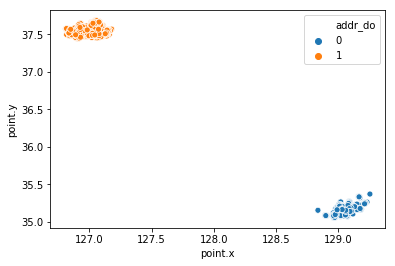

In [27]:
#부산과 서울별로 위도 시각화
#부산은 0, 서울은 1
##hue별로 색깔이 달라짐
sns.scatterplot(x="point.x", y="point.y", hue = "addr_do", data = data)

In [28]:
#파생 변수생성

In [29]:
#총건물 면적 / 총토지 실면적
data["Buliding_area_per_real_area"] = data["Total_building_area"] / data["Total_land_real_area"]

In [30]:
#총토지 경매면적 / 총토지 실면적
data["Per_auction_area"] = data["Total_land_auction_area"] / data["Total_land_real_area"]

In [31]:
#총건물 경매면적 / 총건물면적
data["Per_auction_building_area"] = data["Total_building_auction_area"] / data["Total_building_area"]

In [32]:
#컬럼명 보기
data.columns

Index(['Auction_class', 'Bid_class', 'Claim_price', 'Appraisal_company',
       'Appraisal_date', 'Auction_count', 'Auction_miscarriage_count',
       'Total_land_gross_area', 'Total_land_real_area',
       'Total_land_auction_area', 'Total_building_area',
       'Total_building_auction_area', 'Total_appraisal_price',
       'Minimum_sales_price', 'First_auction_date', 'Final_auction_date',
       'Final_result', 'Creditor', 'addr_do', 'addr_si', 'addr_dong',
       'addr_san', 'addr_bunji1', 'addr_etc', 'Apartment_usage',
       'Preserve_regist_date', 'Total_floor', 'Current_floor',
       'Share_auction_YorN', 'road_name', 'road_bunji1', 'Close_date',
       'Close_result', 'point.y', 'point.x', 'Hammer_price',
       'Buliding_area_per_real_area', 'Per_auction_area',
       'Per_auction_building_area'],
      dtype='object')

In [33]:
# 남은 변수와 상관관계의 절댓값
corr_matrix = data.corr()
abs(corr_matrix["Hammer_price"]).sort_values(ascending=False)

Hammer_price                   1.000000
Minimum_sales_price            0.994592
Total_appraisal_price          0.953464
Total_building_auction_area    0.772839
Total_building_area            0.768454
Total_land_auction_area        0.700639
Total_land_real_area           0.696099
addr_do                        0.306488
point.x                        0.296312
point.y                        0.295698
Claim_price                    0.267728
Total_floor                    0.220830
Current_floor                  0.198013
Bid_class                      0.145528
Per_auction_building_area      0.098673
Per_auction_area               0.097295
Share_auction_YorN             0.091157
Preserve_regist_date           0.074827
Total_land_gross_area          0.070466
Buliding_area_per_real_area    0.059955
Auction_class                  0.054813
road_bunji1                    0.020404
Appraisal_date                 0.020075
Auction_count                  0.016999
First_auction_date             0.012063


In [34]:
# 상관계수 낮은 16개 피쳐 버리기
cor_a = abs(corr_matrix["Hammer_price"]).sort_values(ascending=False)
low_cor_index = cor_a.tail(16).index

In [35]:
data= data.drop(list(low_cor_index),axis=1)

In [36]:
#피쳐가 23개로 감소
data.shape

(1933, 23)

In [37]:
data.columns

Index(['Bid_class', 'Claim_price', 'Appraisal_company', 'Total_land_real_area',
       'Total_land_auction_area', 'Total_building_area',
       'Total_building_auction_area', 'Total_appraisal_price',
       'Minimum_sales_price', 'Final_result', 'Creditor', 'addr_do', 'addr_si',
       'addr_dong', 'addr_san', 'addr_etc', 'Total_floor', 'Current_floor',
       'road_name', 'Close_result', 'point.y', 'point.x', 'Hammer_price'],
      dtype='object')

In [38]:
#Close_result가 모두 배당이므로 삭제
data["Close_result"].unique()

array(['배당', '    '], dtype=object)

In [39]:
data = data.drop("Close_result",axis = 1)

In [40]:
#자세한 주소 컬럼 삭제
del data["addr_dong"]
del data["addr_san"]
del data["addr_etc"]
del data["road_name"]

In [41]:
#분석시 처리하기 힘든 변수 삭제
del data["addr_si"]
del data["Appraisal_company"]
del data["Creditor"]

In [42]:
#모두 낙찰이므로 삭제
data["Final_result"].unique()
del data["Final_result"]

In [43]:
data.columns

Index(['Bid_class', 'Claim_price', 'Total_land_real_area',
       'Total_land_auction_area', 'Total_building_area',
       'Total_building_auction_area', 'Total_appraisal_price',
       'Minimum_sales_price', 'addr_do', 'Total_floor', 'Current_floor',
       'point.y', 'point.x', 'Hammer_price'],
      dtype='object')

In [44]:
#Hammer_price의 중위수
md = np.median(data["Hammer_price"])

In [45]:
#상위 50% = 1 , 하위 50% = 2로 변환하기
data["Hammer_price"] = data.Hammer_price.apply(lambda x: '1' if x>md else '2')

In [46]:
print(data["Hammer_price"])

0       1
1       1
2       2
3       2
4       2
5       2
6       2
7       1
8       2
9       2
10      2
11      2
12      2
13      1
14      1
15      1
16      2
17      2
18      2
19      2
20      2
21      2
22      2
23      1
24      2
25      1
26      2
27      2
28      2
29      2
       ..
1903    2
1904    1
1905    1
1906    2
1907    2
1908    1
1909    1
1910    1
1911    2
1912    1
1913    1
1914    1
1915    2
1916    2
1917    2
1918    1
1919    1
1920    2
1921    1
1922    1
1923    2
1924    1
1925    2
1926    1
1927    2
1928    1
1929    1
1930    1
1931    1
1932    1
Name: Hammer_price, Length: 1933, dtype: object


## 2.모델생성

In [47]:
#1. 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
Y=data['Hammer_price'] 
X=data.drop("Hammer_price", axis = 1)

In [48]:
#모델 생성
log_clf = LogisticRegression() 

In [50]:
# Grid search
# Logistic regression의 하이퍼파라미터는 penalty와 C
# penalty는 패널티 주는 방법이고, C는 SVM의 C와 비슷하다
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(log_clf,grid,cv=5)
logreg_cv.fit(X,Y)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this 

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1'}
accuracy : 0.9606828763579928


In [51]:
#최적의 파라미터는 C = 0.01, penalty = l1
best_logclf=LogisticRegression(C=0.01,penalty="l1")

In [52]:
#모델 정확도 검증 함수
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


def fivefold(x,y,model):
    model_scores = np.zeros(5)
    scores = np.zeros(5)

    cv = KFold(5, shuffle=True, random_state=0)
    for i in range(0,5): #5번의 fold validation
        #train과 test로 데이터 나누기
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
#         #one-hot encoding
#         X_train['Bid_class'] = X_train['Bid_class'].map({'개별':0,'일반':1,'일괄':2})
#         X_test['Bid_class'] = X_test['Bid_class'].map({'개별':0,'일반':1,'일괄':2})
        
        #모델 fit
        result = model.fit(x_train,y_train)

        #prediction
        model_pred = result.predict(x_train)
        pred = result.predict(x_test)
        
        #정확도
        model_accuracy = accuracy_score(y_train, model_pred)
        accuracy = accuracy_score(y_test, pred)

        #test 5번 하나하나 프린트
        #5번의 정확도와 평균 정확도를 프린트
        model_scores[i] = model_accuracy
        scores[i] = accuracy
        print("학습 accuacy = {:.8f}, 검증 accuacy = {:.8f}".format(model_accuracy, accuracy))
    print('평균 train accuacy : ' + str(model_scores.mean()) )
    print('평균 test accuacy : ' + str(scores.mean()) )


In [53]:
#로지스틱 회귀의 5-fold cv 검증
fivefold(X,Y,best_logclf)

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


학습 accuacy = 0.96526238, 검증 accuacy = 0.96724138


C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


학습 accuacy = 0.96008869, 검증 accuacy = 0.97758621


C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


학습 accuacy = 0.96600148, 검증 accuacy = 0.96034483


C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


학습 accuacy = 0.96378418, 검증 accuacy = 0.97068966


C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


학습 accuacy = 0.97413156, 검증 accuacy = 0.95172414
평균 train accuacy : 0.9658536585365853
평균 test accuacy : 0.9655172413793103


In [54]:
#2. knn
from sklearn.neighbors import KNeighborsClassifier

# #이웃의 개수가 5인 knn
# neigh_clf1 = KNeighborsClassifier(n_neighbors=5)
# neigh_clf1.fit(X, Y) 
# #knn의 5-fold cv
# fivefold(X,Y,neigh_clf1)
# # 평균 train accuacy : 0.9733924611973392
# # 평균 test accuacy : 0.9624137931034482

In [55]:
# #이웃의 개수가 10인 knn
# neigh_clf2 = KNeighborsClassifier(n_neighbors=10)
# neigh_clf2.fit(X, Y) 
# #knn의 5-fold cv
# fivefold(X,Y,neigh_clf2)
# # 평균 train accuacy : 0.9683665927568367
# # 평균 test accuacy : 0.9658620689655173

In [56]:
# #이웃의 개수가 20인 knn
# neigh_clf3 = KNeighborsClassifier(n_neighbors=20)
# neigh_clf3.fit(X, Y) 
# #knn의 5-fold cv
# fivefold(X,Y,neigh_clf3)
# # 평균 train accuacy : 0.9673318551367333
# # 평균 test accuacy : 0.9637931034482758

In [57]:
# #이웃의 개수가 50인 knn
# neigh_clf4 = KNeighborsClassifier(n_neighbors=50)
# neigh_clf4.fit(X, Y) 
# #knn의 5-fold cv
# fivefold(X,Y,neigh_clf4)
# # 평균 train accuacy : 0.9654101995565411
# # 평균 test accuacy : 0.9600000000000002

In [58]:
# #이웃의 개수가 70인 knn
# neigh_clf5 = KNeighborsClassifier(n_neighbors=70)
# neigh_clf5.fit(X, Y) 
# #knn의 5-fold cv
# fivefold(X,Y,neigh_clf5)
# # 평균 train accuacy : 0.9651145602365114
# # 평균 test accuacy : 0.9620689655172413

In [59]:
# #이웃의 개수가 100인 knn
# neigh_clf6 = KNeighborsClassifier(n_neighbors=100)
# neigh_clf6.fit(X, Y) 
# #knn의 5-fold cv
# fivefold(X,Y,neigh_clf6)
# # 평균 train accuacy : 0.9503325942350334
# # 평균 test accuacy : 0.9517241379310345

In [60]:
# #이웃의 개수가 150인 knn
# neigh_clf7 = KNeighborsClassifier(n_neighbors=150)
# neigh_clf7.fit(X, Y) 
# #knn의 5-fold cv
# fivefold(X,Y,neigh_clf7)
# # 평균 train accuacy : 0.9441241685144124
# # 평균 test accuacy : 0.9489655172413792

In [61]:
#이웃의 개수가 늘어날수록 train accuracy 감소, test accuracy가 증가
#But 이웃의 개수가 많다고 정확도가 높은 것도 아님!
#train accuracy와 test accuracy의 평균이 높은 5부근에서 grid search

In [62]:
from sklearn.model_selection import cross_val_score

# knn Grid Search

# grid Search 구간 생성
k_range = list(range(1, 10))
#print(k_range)

# 정확도
k_scores = []

# 생성한 구간으로 grid search
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # i에 따라 교차검증으로 정확도 출력
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    # i번째 정확도를 추가
    k_scores.append(scores.mean())
#print(k_scores)

In [63]:
max(k_scores) #0.969478153773616
k_scores.index(max(k_scores)) #정확도가 최대가 되는 인덱스 = 4

4

In [64]:
#grid search 결과 최적의 n_neighbors=5
k_range[4] #5

5

In [65]:
#이웃의 개수가 5인 최적의 knn
neigh_clf = KNeighborsClassifier(n_neighbors=5)
neigh_clf.fit(X, Y) 
#knn의 5-fold cv
fivefold(X,Y,neigh_clf)

학습 accuacy = 0.97117517, 검증 accuacy = 0.97241379
학습 accuacy = 0.97930525, 검증 accuacy = 0.95344828
학습 accuacy = 0.96895787, 검증 accuacy = 0.96551724
학습 accuacy = 0.97265336, 검증 accuacy = 0.97241379
학습 accuacy = 0.97117517, 검증 accuacy = 0.96896552
평균 train accuacy : 0.9726533628972653
평균 test accuacy : 0.9665517241379311


In [66]:
#SVM
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#피쳐 개수가 적고 데이터 개수가 보통이므로 RBF kernel을 사용하면 좋을거같음
#혹시 모르니 grid Search로 검증해보자

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC



#Pipeline으로 모형 만들어놓기
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

#param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_range = [1, 10, 100]

In [68]:
#SVM의 Parameter grid
param_grid = [
    {'clf__C': param_range, 'clf__kernel': ['linear']},
    {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

In [69]:
#위의 grid로 grid Search
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                   scoring='accuracy', cv=5, n_jobs=1)

In [70]:
gs.fit(X, Y)

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converte

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'clf__C': [1, 10, 100], 'clf__kernel': ['linear']}, {'clf__C': [1, 10, 100], 'clf__gamma': [1, 10, 100], 'clf__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [71]:
gs.cv_results_["mean_test_score"]

array([0.93016037, 0.94309364, 0.9508536 , 0.89756855, 0.85928608,
       0.61562338, 0.91257113, 0.8680807 , 0.6378686 , 0.90998448,
       0.8680807 , 0.6378686 ])

In [72]:
#주어진 파라미터 grid에서 최적의 모형은 C = 100, kernel = linear
print(gs.best_score_)
print(gs.best_params_)

0.9508535954474909
{'clf__C': 100, 'clf__kernel': 'linear'}


In [87]:
#linear SVM의 평균 test score
#C = 100부근에서 높음
gs.cv_results_["mean_test_score"][0:3]

array([0.93016037, 0.94309364, 0.9508536 ])

In [90]:
#선형 SVM에서 최적의 C 찾기(grid search)
param_range2 = [70,80,90,100,110,120,130]
param_grid2 = {'clf__C': param_range2, 'clf__kernel': ['linear']}

In [91]:
gs2 = GridSearchCV(estimator=pipe_svc, param_grid=param_grid2,
                   scoring='accuracy', cv=5, n_jobs=1)

In [92]:
gs2.fit(X, Y)

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 wer

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all conv

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converte

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=1,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'clf__C': [70, 80, 90, 100, 110, 120, 130], 'clf__kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [93]:
gs2.cv_results_["mean_test_score"]

array([0.94878427, 0.94981893, 0.9508536 , 0.9508536 , 0.95137093,
       0.94878427, 0.94774961])

In [94]:
#주어진 파라미터 grid에서 최적의 모형은 C = 110, kernel = linear
print(gs2.best_score_)
print(gs2.best_params_)

0.9513709260217279
{'clf__C': 110, 'clf__kernel': 'linear'}


In [95]:
#따라서 grid search 결과 최적의 모형은 C = 110, kernel = linear
from sklearn.svm import LinearSVC
best_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=110, random_state=1))
])


In [96]:
#모델 fit
best_svm.fit(X,Y)

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=110, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0))])

In [98]:
# SVM 5-fold cross validation
fivefold(X,Y,best_svm)

C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converte

학습 accuacy = 0.96969697, 검증 accuacy = 0.96724138


C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converte

학습 accuacy = 0.96969697, 검증 accuacy = 0.95862069


C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converte

학습 accuacy = 0.97117517, 검증 accuacy = 0.96034483


C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converte

학습 accuacy = 0.96156689, 검증 accuacy = 0.96379310


C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dmstj\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converte

학습 accuacy = 0.97043607, 검증 accuacy = 0.97068966
평균 train accuacy : 0.9685144124168514
평균 test accuacy : 0.9641379310344828
